/tmp/ipykernel_134136/2516159834.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, x = wavfile.read("input.wav")


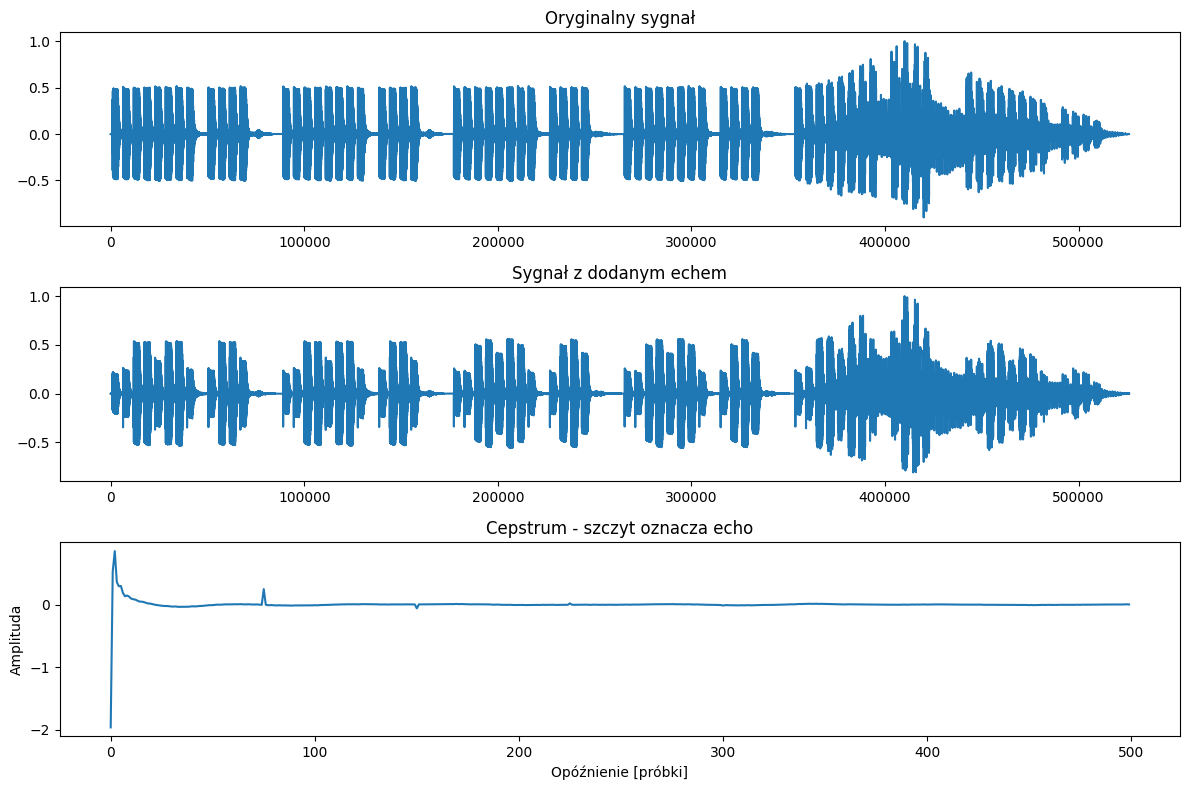

Wykryto echo przy opóźnieniu ≈ 75 próbek
Czas opóźnienia ≈ 0.0017 s


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from scipy.fft import fft, ifft
from scipy.io import wavfile

# --- 1. Wczytanie pliku ---
rate, x = wavfile.read("input.wav")

# Konwersja do mono, jeśli stereo
if x.ndim > 1:
    x = x[:, 0]

# Konwersja na float i normalizacja do [-1, 1]
x = x.astype(np.float32)
x = x / np.max(np.abs(x))

# --- 2. Dodanie echa ---
alpha = 0.5  # siła echa (0–1)
delta = 75  # opóźnienie w próbkach (~45 ms przy 44.1 kHz)

y = np.copy(x)
if delta < len(x):
    y[delta:] += alpha * x[:-delta]

# Normalizacja po dodaniu echa (żeby nie przesterować)
y = y / np.max(np.abs(y))

# Zapis poprawnego pliku
sf.write("output_with_echo.wav", y, rate)

# --- 3. Obliczanie cepstrum ---
X = fft(y)
cepstrum = np.real(ifft(np.log(np.abs(X) + 1e-10)))

# --- 4. Wizualizacja ---
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

# Oryginał
axs[0].plot(x)
axs[0].set_title("Oryginalny sygnał")

# Z echem
axs[1].plot(y)
axs[1].set_title("Sygnał z dodanym echem")

# Cepstrum
axs[2].plot(cepstrum[:500])
axs[2].set_title("Cepstrum - szczyt oznacza echo")
axs[2].set_xlabel("Opóźnienie [próbki]")
axs[2].set_ylabel("Amplituda")

plt.tight_layout()
plt.show()

# --- 5. Wykrycie echa ---
search_start = 20  # pomijamy okolice zera
search_end = 500
peak_index = np.argmax(cepstrum[search_start:search_end]) + search_start

print(f"Wykryto echo przy opóźnieniu ≈ {peak_index} próbek")
print(f"Czas opóźnienia ≈ {peak_index / rate:.4f} s")


/tmp/ipykernel_134136/480734228.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, x = wavfile.read("input.wav")


[DETEKCJA] delta (oczekiwane ~75) = 75 próbek, 0.001701 s
[WZORZEC] Hamming distance = 0.0996  |  Accuracy = 0.9004


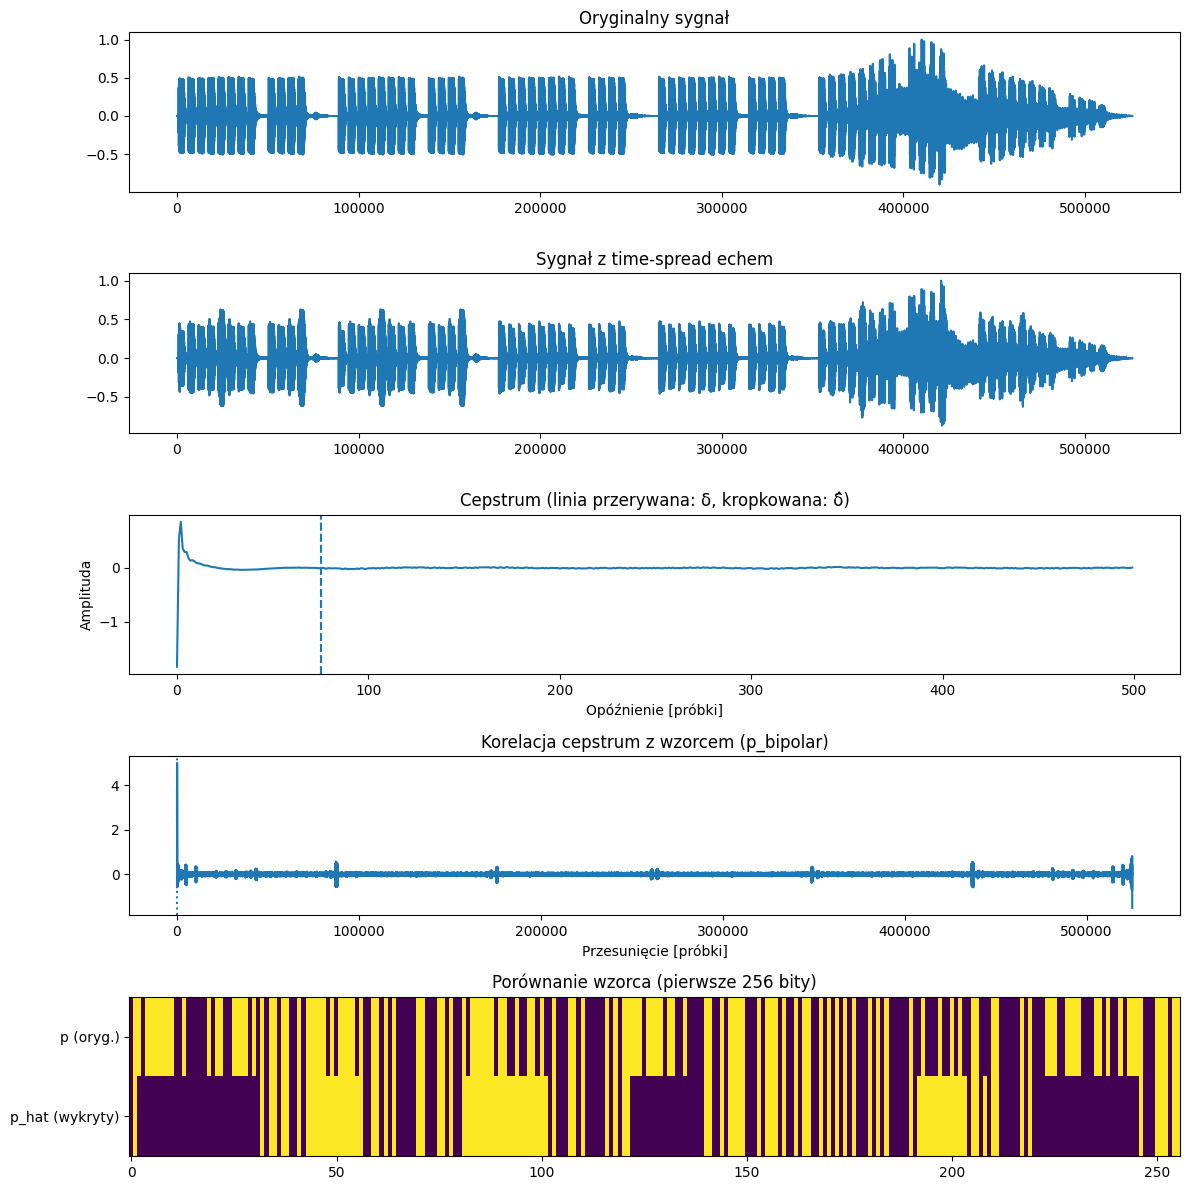

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.io import wavfile
from scipy.fft import fft, ifft

# --- 1. Wczytanie pliku i przygotowanie ---
rate, x = wavfile.read("input.wav")
if x.ndim > 1:
    x = x[:, 0]
x = x.astype(np.float32)
x = x / (np.max(np.abs(x)) + 1e-12)

# --- 2. Wzorzec time-spread ---
L = 1024
np.random.seed(0)  # stała losowość dla powtarzalności
p = np.random.choice([0, 1], size=L)
p_bipolar = 2 * p - 1  # 0/1 -> -1/+1

# --- 3. Osadzenie time-spread echo ---
alpha = 0.01
delta = 75  # bazowe opóźnienie (quefrency start)
y = np.copy(x)

N = len(x)
for i in range(L):
    shift = delta + i
    if shift < N:
        y[shift:] += alpha * p_bipolar[i] * x[:-shift]

# Normalizacja po osadzeniu
y = y / (np.max(np.abs(y)) + 1e-12)
sf.write("output_timespread.wav", y, rate)

# --- 4. Cepstrum ---
Y = fft(y)
cepstrum = np.real(ifft(np.log(np.abs(Y) + 1e-10)))

# --- 5. Korelacja cepstrum z p_bipolar i detekcja opóźnienia ---
corr = np.correlate(cepstrum, p_bipolar, mode='valid')

# Pomijamy okolice zera (duża energia)
search_start = 20
search_end = min(5000, len(corr))  # górny limit opcjonalny
peak_idx_rel = np.argmax(corr[search_start:search_end]) + search_start
delta_hat = peak_idx_rel  # to jest start wzorca w cepstrum

# --- 6. Rekonstrukcja wzorca z danych ---
# Upewnij się, że mamy pełne L próbek od delta_hat
if delta_hat + L > len(cepstrum):
    L_eff = len(cepstrum) - delta_hat
else:
    L_eff = L

seg = cepstrum[delta_hat:delta_hat + L_eff]

# Z-score segmentu (stabilniejsze prógowanie)
seg_z = (seg - np.mean(seg)) / (np.std(seg) + 1e-12)

# Odzyskany wzorzec bipolarny ze znaku segmentu
p_hat_bipolar = np.sign(seg_z)
p_hat_bipolar[p_hat_bipolar == 0] = 1  # gdy 0, wybierz +1

# Na długość L (jeśli końcówka brakująca, uzupełnij +1)
if L_eff < L:
    pad = np.ones(L - L_eff, dtype=np.float32)
    p_hat_bipolar = np.concatenate([p_hat_bipolar, pad])

# Mapowanie na 0/1
p_hat = ((p_hat_bipolar + 1) // 2).astype(int)

# --- 7. Porównanie z oryginałem ---
hamming = np.mean(p_hat != p)
accuracy = 1.0 - hamming

print(f"[DETEKCJA] delta (oczekiwane ~{delta}) = {delta_hat} próbek, {delta_hat / rate:.6f} s")
print(f"[WZORZEC] Hamming distance = {hamming:.4f}  |  Accuracy = {accuracy:.4f}")

# --- 8. Wizualizacja ---
fig, axs = plt.subplots(5, 1, figsize=(12, 12))

axs[0].plot(x)
axs[0].set_title("Oryginalny sygnał")

axs[1].plot(y)
axs[1].set_title("Sygnał z time-spread echem")

axs[2].plot(cepstrum[:max(500, delta + L // 8)])
axs[2].axvline(delta, ls='--')
axs[2].axvline(delta_hat, ls=':')
axs[2].set_title("Cepstrum (linia przerywana: δ, kropkowana: δ̂)")
axs[2].set_xlabel("Opóźnienie [próbki]")
axs[2].set_ylabel("Amplituda")

axs[3].plot(corr)
axs[3].axvline(delta_hat, ls=':')
axs[3].set_title("Korelacja cepstrum z wzorcem (p_bipolar)")
axs[3].set_xlabel("Przesunięcie [próbki]")

# Porównanie p i p_hat jako mapy bitów
show_len = 256  # skrót do czytelnej wizualizacji
P = np.vstack([p[:show_len], p_hat[:show_len]])
axs[4].imshow(P, aspect='auto', interpolation='nearest')
axs[4].set_yticks([0, 1])
axs[4].set_yticklabels(["p (oryg.)", "p_hat (wykryty)"])
axs[4].set_title(f"Porównanie wzorca (pierwsze {show_len} bity)")

plt.tight_layout()
plt.show()
